In [1]:
import numpy as np
import scipy.stats as stats
from scipy.signal import find_peaks
import pandas as pd 
import matplotlib.pyplot as plt      
import torch
import seaborn as sns

# Necessary functions to preprocess the data, get the features and plot them


In [2]:
# initial dataframe
def pre_process(data_path,timestamps=None,normalize=False):
    data=pd.read_excel(data_path)
    # print("The RAW DATA info is:")
    # data.info()

    #preprocessing to get it in my order
    df=data.copy() #copying it so original data is not affected
    df=df.dropna()
    df=df.drop(["Time - Voltage","Time - Resistance","Time - Force"],axis=1)
    df=df.rename({
        "Time - Current":"Time",
        "Current (kA) - Current":"Current (kA)",
        "Voltage (V) - Voltage":"Voltage (V)",
        "Resistance (Ohm) - Resistance":"Resistance (Ohm)",
        "Force (kg) - Force":"Force (kgf)"
    },axis=1)

    if normalize:
        df=(df-df.mean())/df.std()
        return df
    elif timestamps is not None:
        df=df.loc[timestamps]
        return df
    else:
        return df
    # print("\n the formatted data info is: ")
    # df.info()

In [3]:

def get_features(sensor,timestamps=None,spotf=1,spotl=69,normalize=False):
    feature_list={'mean':[],
                'median':[],
                'mode':[],
                'std':[],
                'max':[],
                "min":[],
                # "skew":[],
                # "kurt":[],
                "q_25":[],
                "q_50":[],
                "q_75":[],
                # "cov":[],
                "peaks":[]
                }
    for i in range(spotf,spotl,1):
        data_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{i}.xlsx"
        df=pre_process(data_path,timestamps=timestamps,normalize=normalize)
        signal=np.array(df[sensor])
        signal_norm=(signal-np.mean(signal))/np.std(signal)

        feature_list["mean"].append(np.round(np.mean(signal),4))
        feature_list['median'].append(np.round(np.median(signal),4))
        feature_list['mode'].append(np.round(stats.mode(signal, keepdims=True)[0][0],4))
        feature_list['std'].append(np.round(np.std(signal),4))
        feature_list['max'].append(np.round(np.max(signal),4))
        feature_list['min'].append(np.round(np.min(signal),4))
        # feature_list['skew'].append(np.round(stats.skew(signal),4))
        # feature_list['kurt'].append(np.round(stats.kurtosis(signal),4))
        feature_list['q_25'].append(np.round(np.percentile(signal, [25]),4))
        feature_list['q_50'].append(np.round(np.percentile(signal, [50]),4))
        feature_list['q_75'].append(np.round(np.percentile(signal, [75]),4))
        # feature_list['cov'].append(np.round(np.std(signal) / np.mean(signal),4))
        peaks, _ = find_peaks(signal)
        feature_list['peaks'].append(len(peaks))

    return feature_list


In [49]:
def plot_features(dataframe,sensor,features,trend=True,deg=1,units='none'):
    n_features=len(dataframe.columns)
    n_cols=1
    n_rows=-(-n_features//n_cols)

    fig, axes= plt.subplots(n_rows,n_cols, figsize=(60,15*n_rows))
    axes=axes.flatten()
    # plt.suptitle(f"Extracted features of {sensor}",fontsize=16)

    for i, feature in enumerate(features):
        axes[i].plot(dataframe.index,dataframe[feature],'o-',label=f'{sensor} {feature}')
        axes[i].set_title(f"{sensor} {feature}",fontsize=30)
        axes[i].set_xlabel("Spot No.",fontsize=24)
        axes[i].set_ylabel(f"{feature} ({units})",fontsize=24)
        axes[i].grid(True)
        axes[i].set_xticks(np.arange(1,dataframe.shape[0]+1,1),fontsize=16)
        if trend:
            coeffs = np.polyfit(dataframe.index,dataframe[feature] , deg=deg)
            trendline = np.polyval(coeffs, dataframe.index)
            axes[i].plot(dataframe.index, trendline, color='red', label='Linear Trendline',linestyle='dashed')
        axes[i].legend(fontsize=24)

    for j in range(i+1,len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist

def get_rp_matrix(signal_values,N=0):
    # --- Input: 1D signal from your dataframe ---
    signal = signal_values.values.astype(np.float32)

    # --- Optional: Normalize signal to [0, 1] for better image quality ---
    scaler = MinMaxScaler()
    signal=signal[signal>0]
    
    signal = scaler.fit_transform(signal.reshape(-1, 1)).flatten()
    if N==0:
        dists = pdist(signal.reshape(-1, 1))
        N = np.percentile(dists, 90)


    # --- Generate modified recurrence plot ---
    K = len(signal)
    rp_matrix = np.zeros((K, K), dtype=np.float32)

    for i in range(K):
        for j in range(K):
            diff = abs(signal[i] - signal[j])
            rp_matrix[i, j] = N if diff > N else diff

    # --- Optional: Normalize for better image contrast ---
    rp_matrix = (rp_matrix - rp_matrix.min()) / (rp_matrix.max() - rp_matrix.min())

    return rp_matrix

In [6]:
def get_df_sensor(sensor,spotf,spotl,timestamps=None):
    big_data=pd.DataFrame()
    for i in range(spotf,spotl+1,1):
        data_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{i}.xlsx"
        df=pre_process(data_path=data_path,timestamps=timestamps)
        if timestamps is not None:
            cols=timestamps
            row=pd.DataFrame([df[sensor]],columns=cols)
        else:
            row=pd.DataFrame([df[sensor]],columns=np.arange(1,764,1))
        row.index=[i]
        big_data=pd.concat([big_data,row])
    return big_data.T

In [7]:
from scipy.stats import zscore
def compute_scf(data,slope=4,shift=2,time=np.arange(1,764,1)):
    data_z = data.apply(zscore, axis=0)

    t = time  # time indices
    a = slope  # slope parameter (from paper's weight function)
    b = shift  # shift parameter

    weights = 1 / (1 + np.exp(-(t - b * 100) / a))  # Scaled for 763 points
    weights = weights / np.sum(weights)

    reference_signal = data_z.iloc[:, 0]

    scf_values = {}
    for col in data_z.columns:
        current_signal = data_z[col]
        scf = np.sqrt(np.sum(weights * (current_signal - reference_signal) ** 2))
        scf_values[col] = scf

    scf_df = pd.DataFrame.from_dict(scf_values, orient='index', columns=['SCF'])
    return scf_df

# Here we can call for features instance and next plot them


In [8]:
# timestamps=np.arange(118,713,1)
timestamps=None

# extracting all the statistical features for each sensor
feature_list_Resistance=get_features(sensor="Resistance (Ohm)",spotf=1,spotl=69,normalize=False,timestamps=timestamps)
feature_list_Force=get_features(sensor="Force (kgf)",spotf=1,spotl=69,normalize=False,timestamps=timestamps)
feature_list_Current=get_features(sensor="Current (kA)",spotf=1,spotl=69,normalize=False,timestamps=timestamps)
feature_list_Voltage=get_features(sensor='Voltage (V)',spotf=1,spotl=69,normalize=False,timestamps=timestamps)

# creating respective dataframes

df_Resistance=pd.DataFrame(feature_list_Resistance,columns=feature_list_Resistance.keys())
# #normalizing features
# df_Resistance= (df_Resistance - df_Resistance.mean()) / df_Resistance.std()
df_Resistance.index = range(1, len(df_Resistance) + 1)

df_Current=pd.DataFrame(feature_list_Current,columns=feature_list_Current.keys())
# #normalizing features
# df_Current= (df_Current - df_Current.mean()) / df_Current.std()
df_Current.index = range(1, len(df_Current) + 1)

df_Force=pd.DataFrame(feature_list_Force,columns=feature_list_Force.keys())
# #normalizing features
# df_Force= (df_Force - df_Force.mean()) / df_Force.std()
df_Force.index = range(1, len(df_Force) + 1)

df_Voltage=pd.DataFrame(feature_list_Voltage,columns=feature_list_Voltage.keys())
# #normalizing features
# df_Force= (df_Force - df_Force.mean()) / df_Force.std()
df_Voltage.index = range(1, len(df_Voltage) + 1)




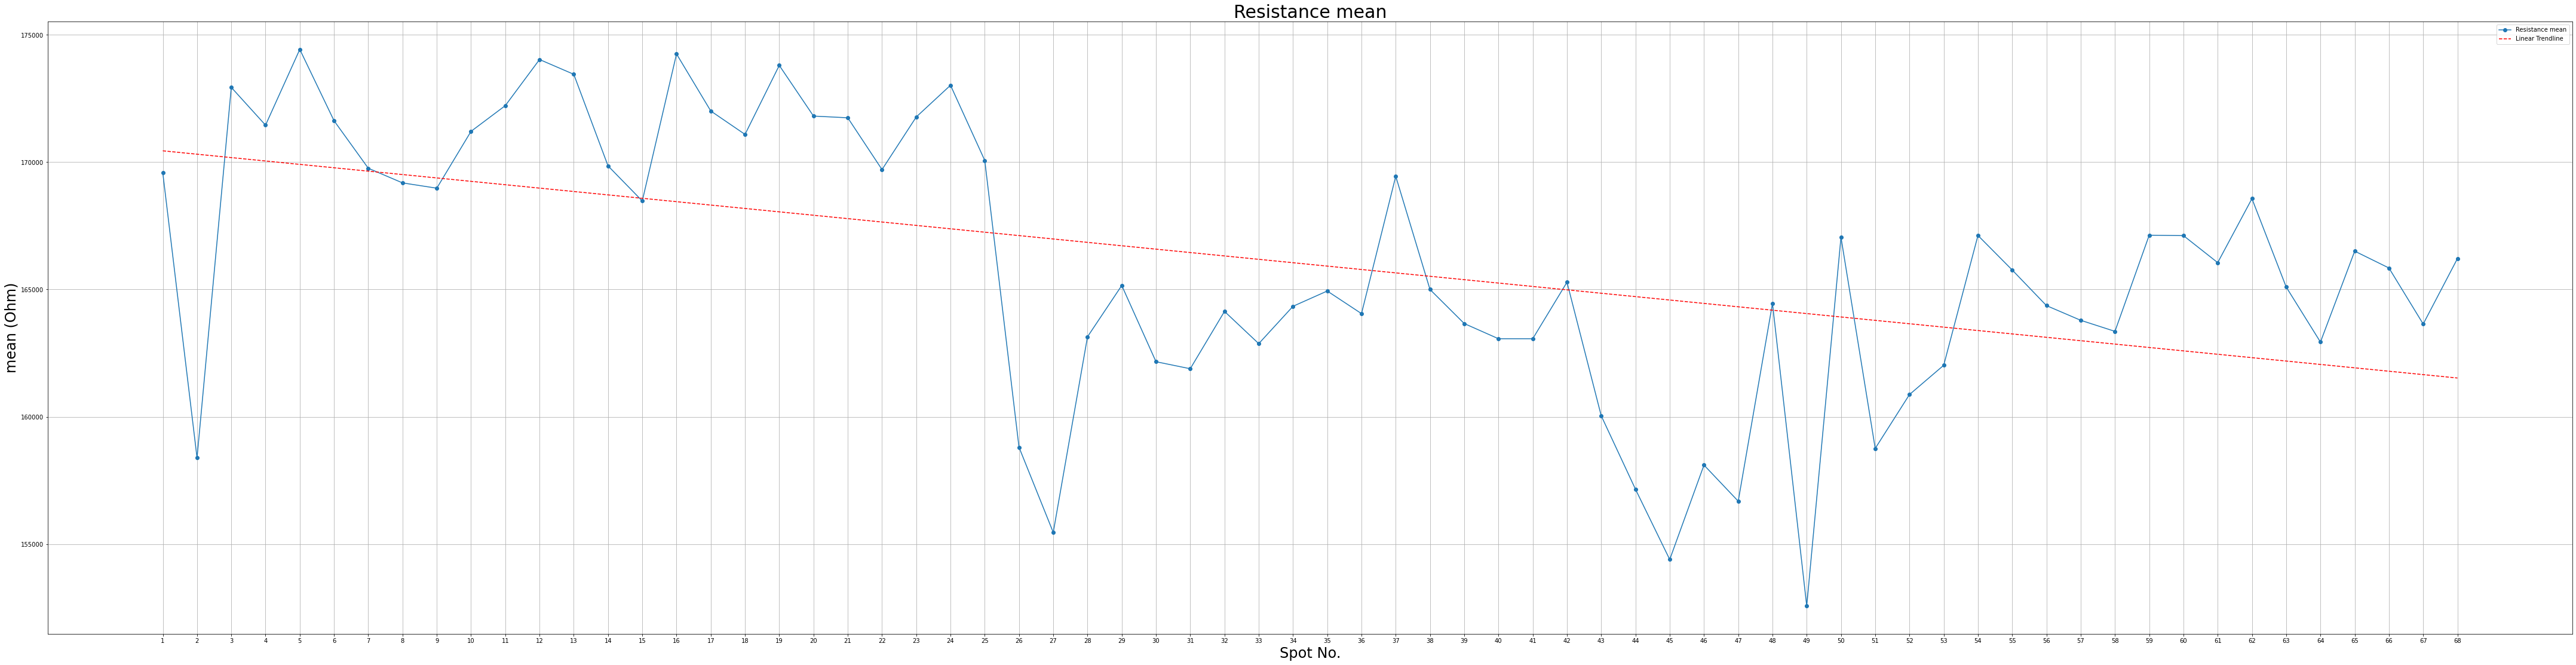

In [46]:
# plotting extracted features for each sensor

plot_features(dataframe=df_Resistance,sensor="Resistance",features=['mean'],trend=True,deg=1,units='Ohm')

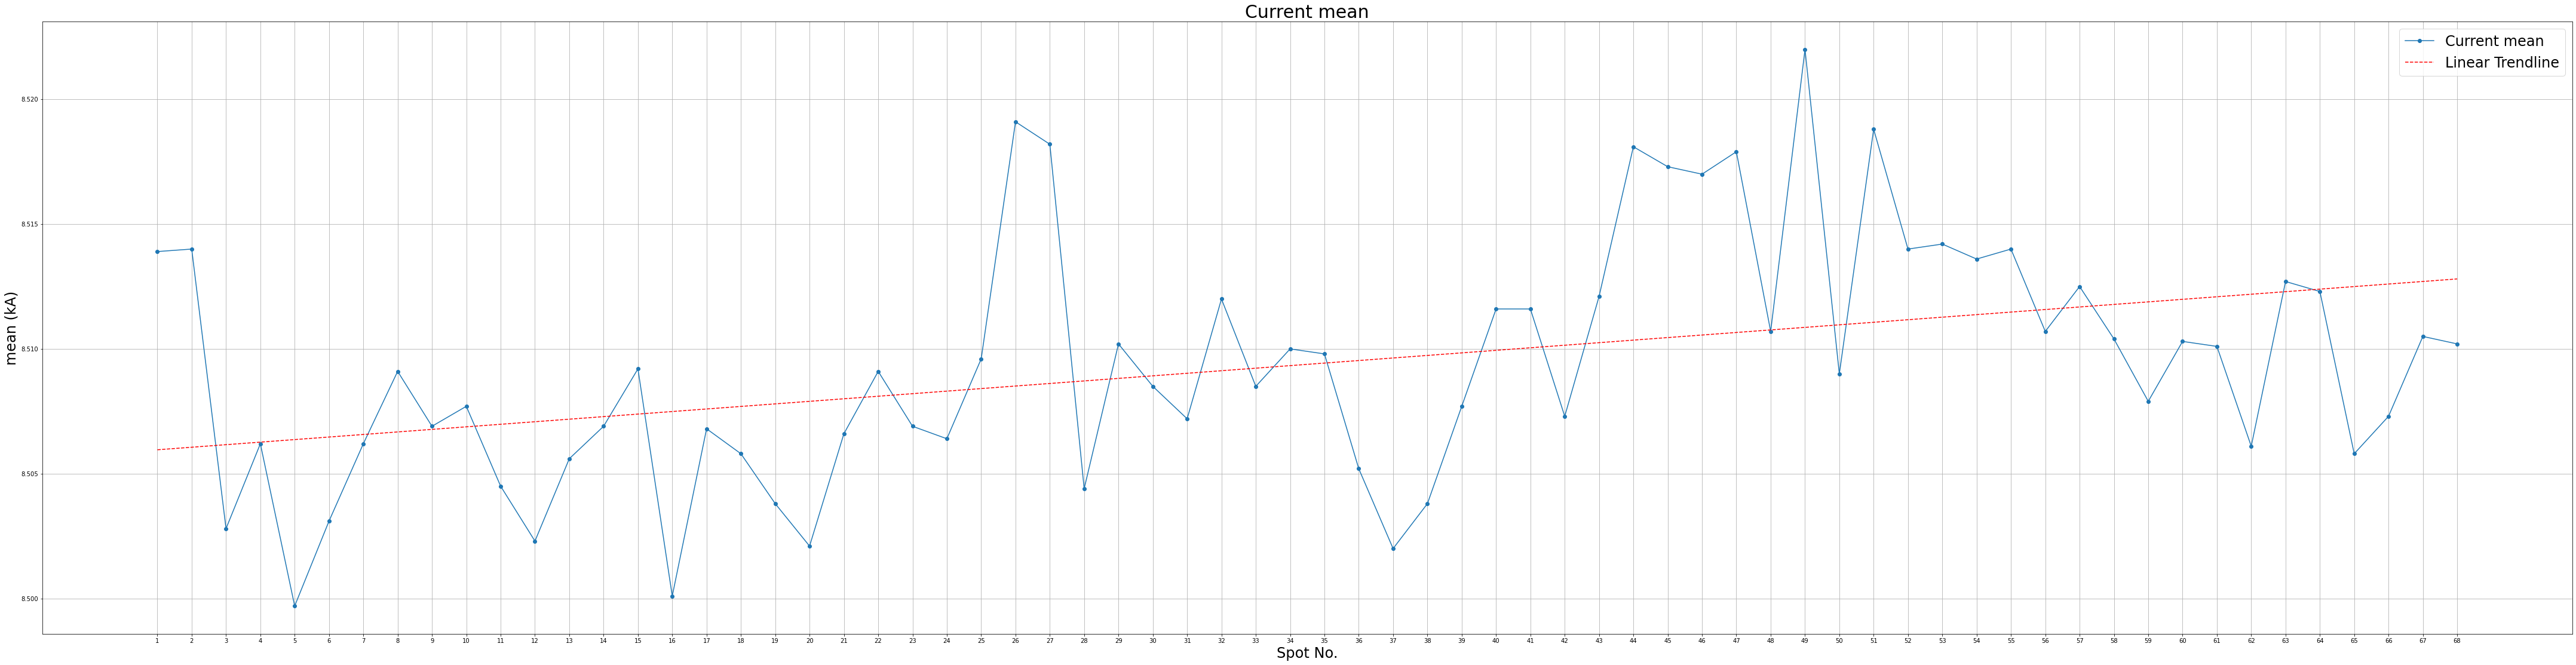

In [50]:
plot_features(dataframe=df_Current,sensor="Current",features=['mean'],trend=True,deg=1,units='kA')

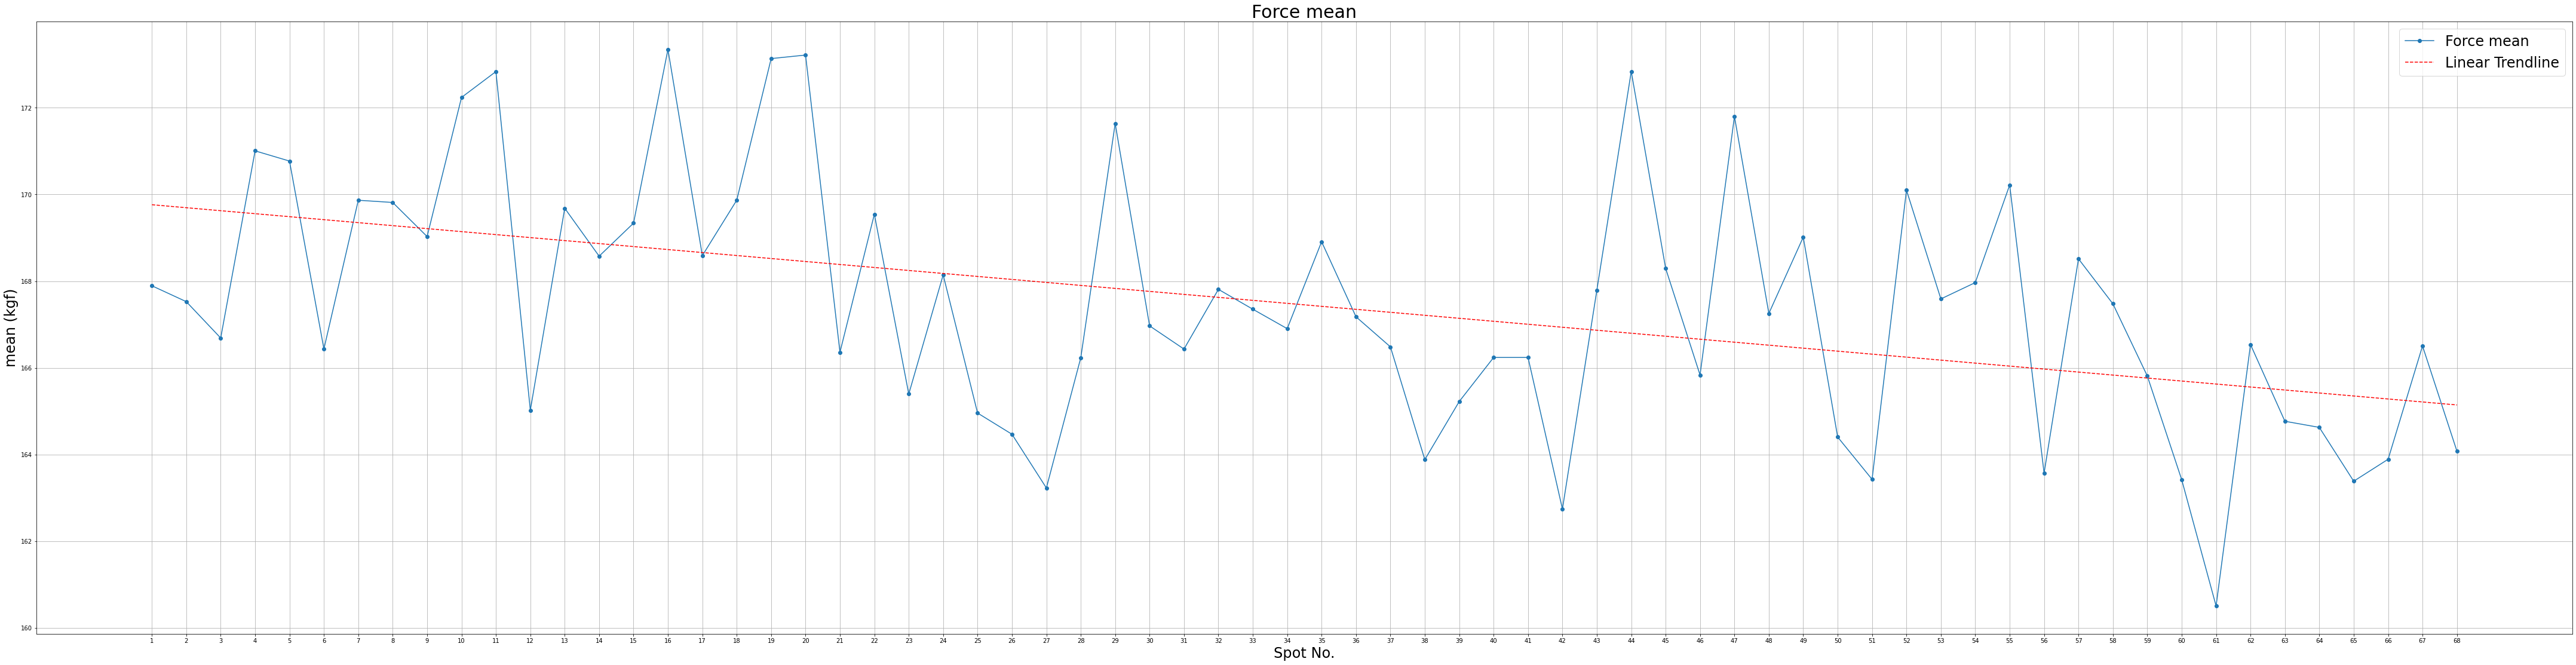

In [51]:
plot_features(dataframe=df_Force,sensor='Force',features=['mean'],trend=True,deg=1,units='kgf')

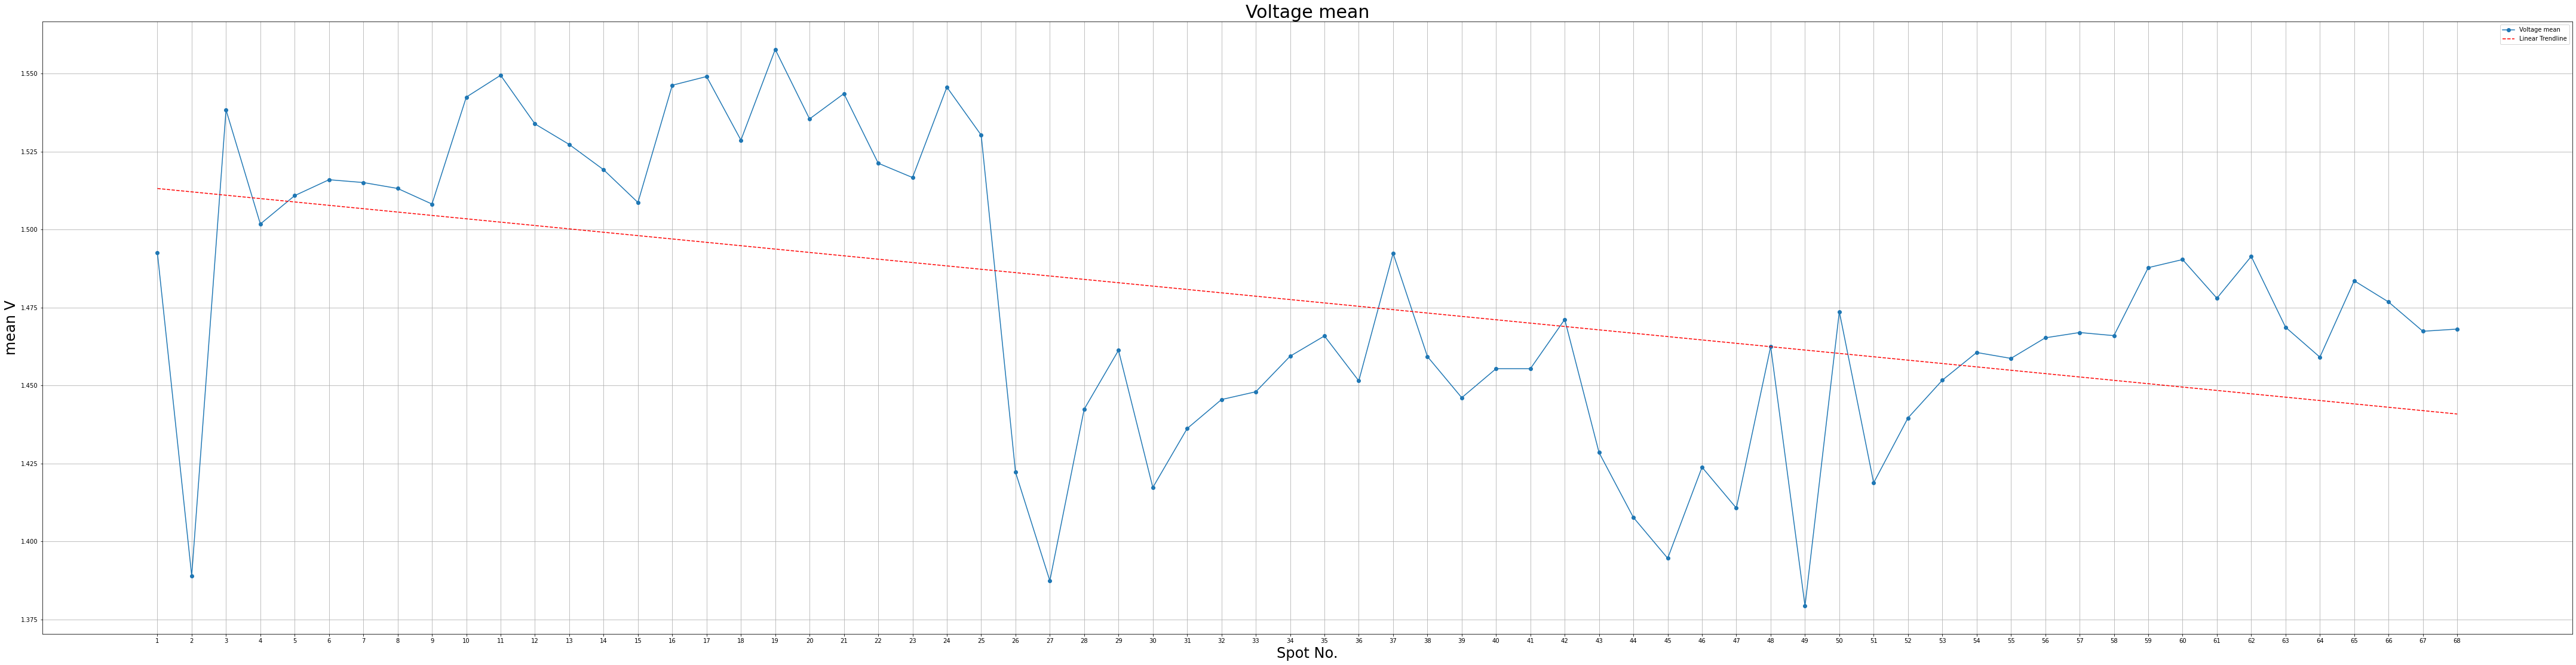

In [44]:
plot_features(dataframe=df_Voltage,sensor='Voltage',features=['mean'],deg=1,trend=True,units='V')

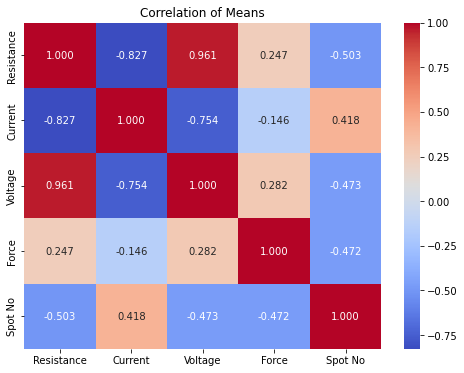

In [34]:
df_combined = pd.DataFrame({
    'Resistance': df_Resistance['mean'],
    'Current': df_Current['mean'],
    'Voltage': df_Voltage['mean'],
    'Force': df_Force['mean'],
    'Spot No' :df_Resistance.index.values
})

# Compute the correlation matrix
corr = df_combined.corr()

# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Correlation of Means')
plt.show()

# df_Resistance.index.values

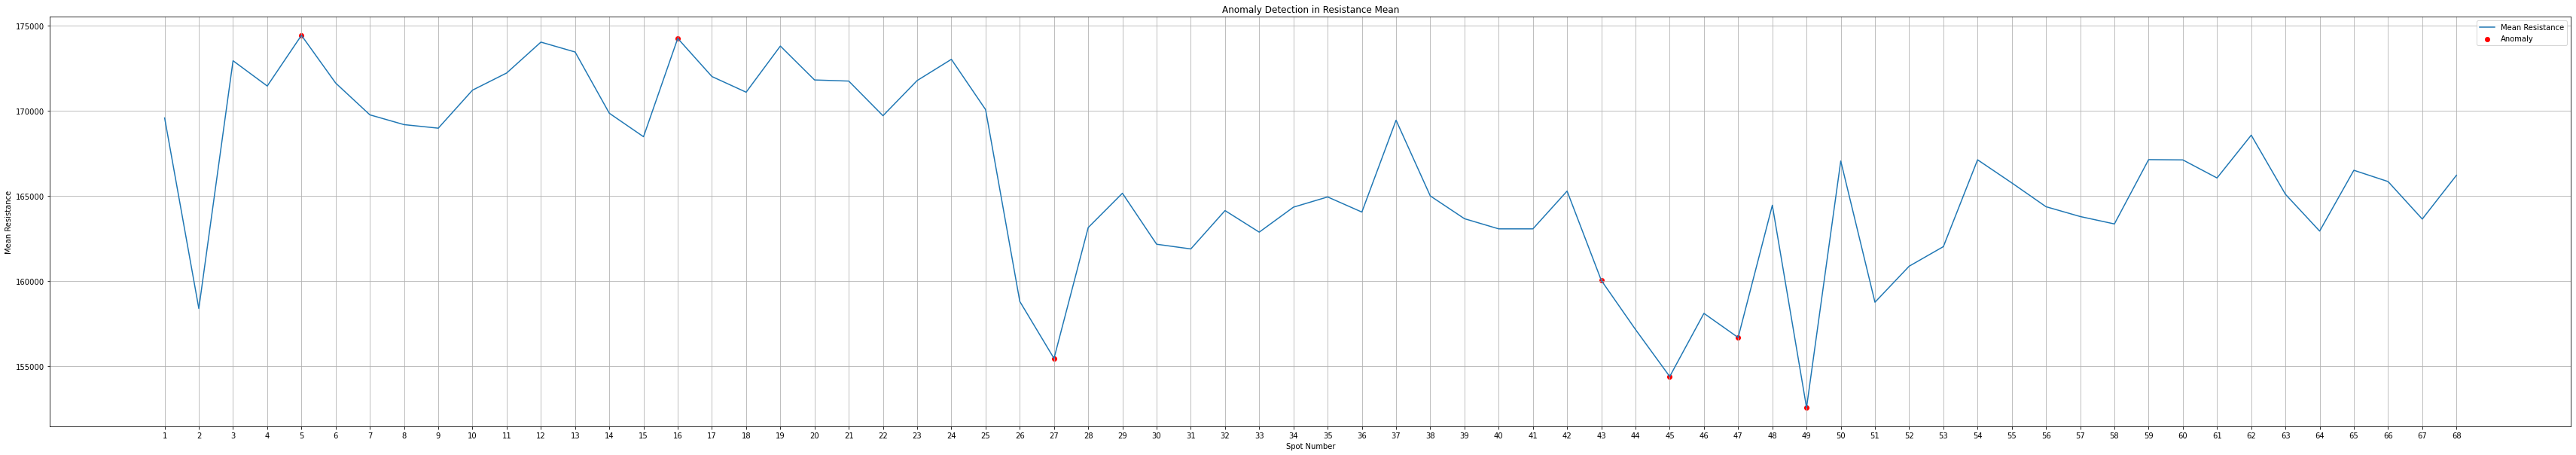

Anomalous spots: [5, 16, 27, 43, 45, 47, 49]


In [15]:
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt

resistance_means=df_Resistance['mean']
spot_numbers=df_Resistance.index.values

X = np.array(resistance_means).reshape(-1, 1)  # Mean resistance

# Train anomaly detector
iso = IsolationForest(contamination=0.1)  # 5% expected anomalies
labels = iso.fit_predict(X)  # -1 = anomaly, 1 = normal

# Plot
plt.figure(figsize=(60, 10))
plt.plot(spot_numbers, resistance_means,label='Mean Resistance')
plt.scatter(np.array(spot_numbers)[labels == -1],
            np.array(resistance_means)[labels == -1],
            color='red', label='Anomaly')
plt.xlabel("Spot Number")
plt.xticks(np.array(spot_numbers))
plt.ylabel("Mean Resistance")
plt.legend()
plt.title("Anomaly Detection in Resistance Mean")
plt.grid(True)
plt.show()

# Get detected anomalous spots
anomalous_spots = [spot for spot, label in zip(spot_numbers, labels) if label == -1]
print("Anomalous spots:", anomalous_spots)


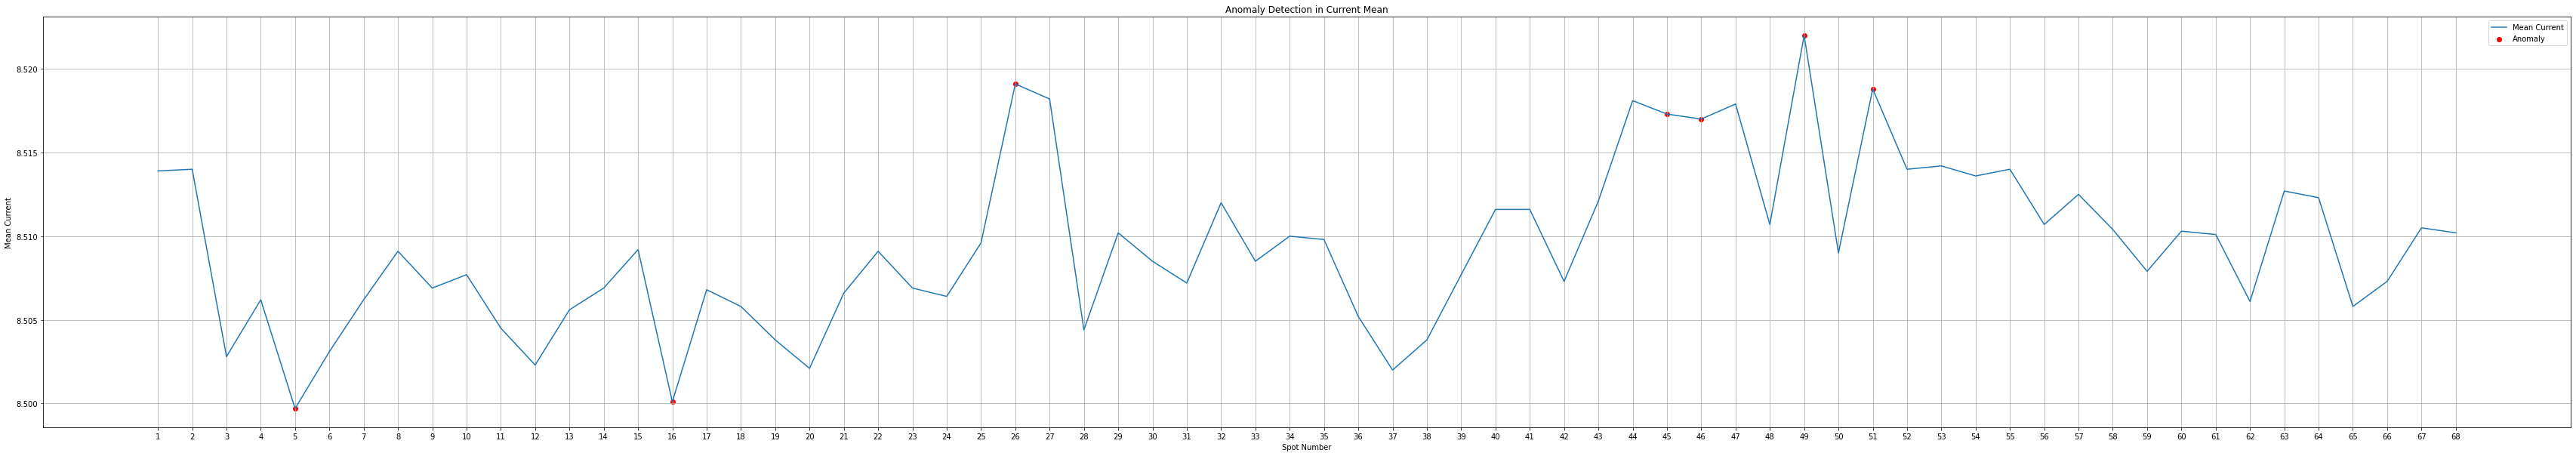

Anomalous spots: [5, 16, 26, 45, 46, 49, 51]


In [16]:
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt

current_means=df_Current['mean']
spot_numbers=df_Current.index.values

X = np.array(current_means).reshape(-1, 1)  # Mean resistance

# Train anomaly detector
iso = IsolationForest(contamination=0.1)  # 5% expected anomalies
labels = iso.fit_predict(X)  # -1 = anomaly, 1 = normal

# Plot
plt.figure(figsize=(60, 10))
plt.plot(spot_numbers, current_means,label='Mean Current')
plt.scatter(np.array(spot_numbers)[labels == -1],
            np.array(current_means)[labels == -1],
            color='red', label='Anomaly')
plt.xlabel("Spot Number")
plt.xticks(np.array(spot_numbers))
plt.ylabel("Mean Current")
plt.legend()
plt.title("Anomaly Detection in Current Mean")
plt.grid(True)
plt.show()

# Get detected anomalous spots
anomalous_spots = [spot for spot, label in zip(spot_numbers, labels) if label == -1]
print("Anomalous spots:", anomalous_spots)


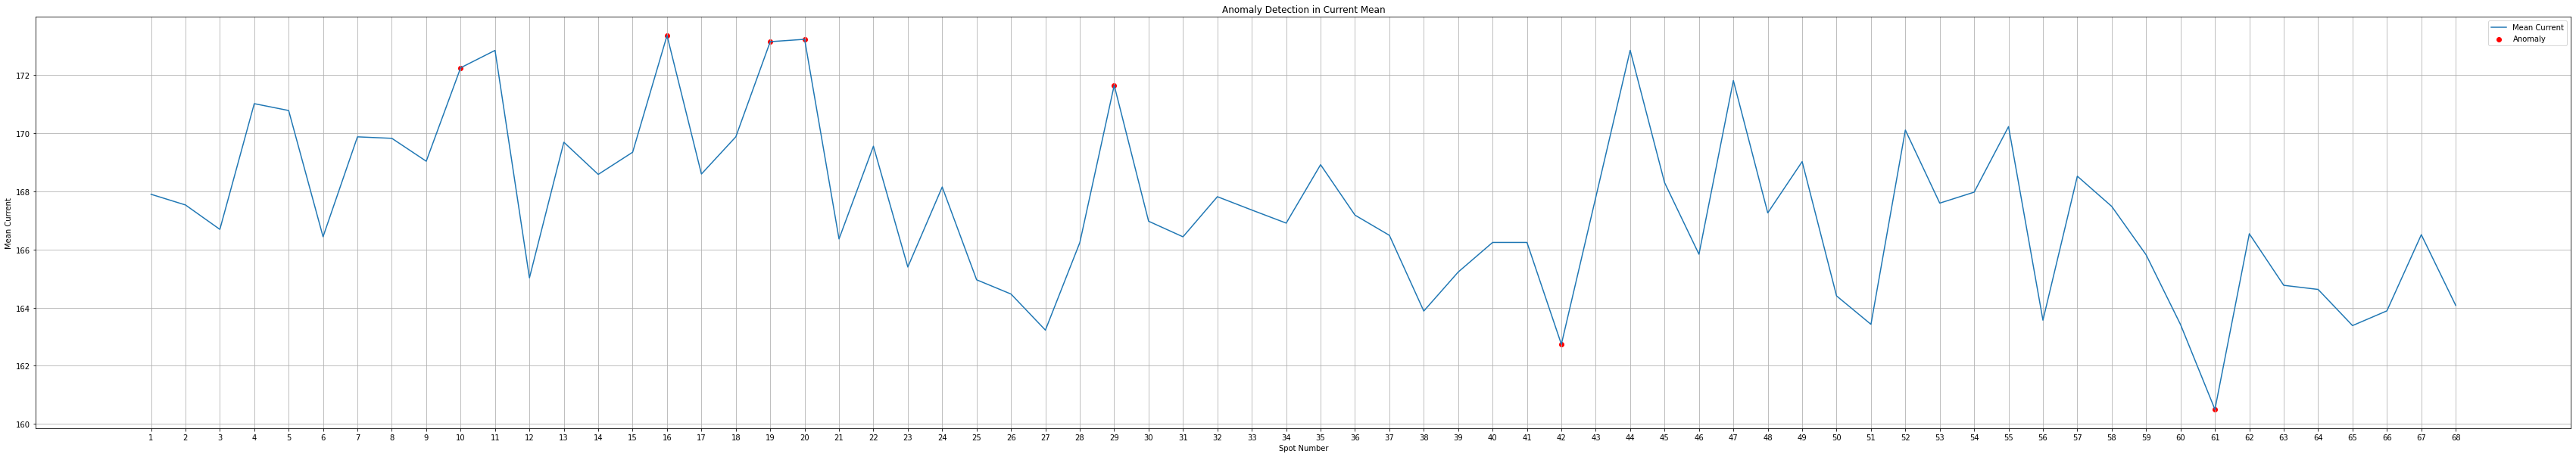

Anomalous spots: [10, 16, 19, 20, 29, 42, 61]


In [17]:
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt

force_means=df_Force['mean']
spot_numbers=df_Force.index.values

X = np.array(force_means).reshape(-1, 1)  # Mean resistance

# Train anomaly detector
iso = IsolationForest(contamination=0.1)  # 5% expected anomalies
labels = iso.fit_predict(X)  # -1 = anomaly, 1 = normal

# Plot
plt.figure(figsize=(60, 10))
plt.plot(spot_numbers, force_means,label='Mean Current')
plt.scatter(np.array(spot_numbers)[labels == -1],
            np.array(force_means)[labels == -1],
            color='red', label='Anomaly')
plt.xlabel("Spot Number")
plt.xticks(np.array(spot_numbers))
plt.ylabel("Mean Current")
plt.legend()
plt.title("Anomaly Detection in Current Mean")
plt.grid(True)
plt.show()

# Get detected anomalous spots
anomalous_spots = [spot for spot, label in zip(spot_numbers, labels) if label == -1]
print("Anomalous spots:", anomalous_spots)


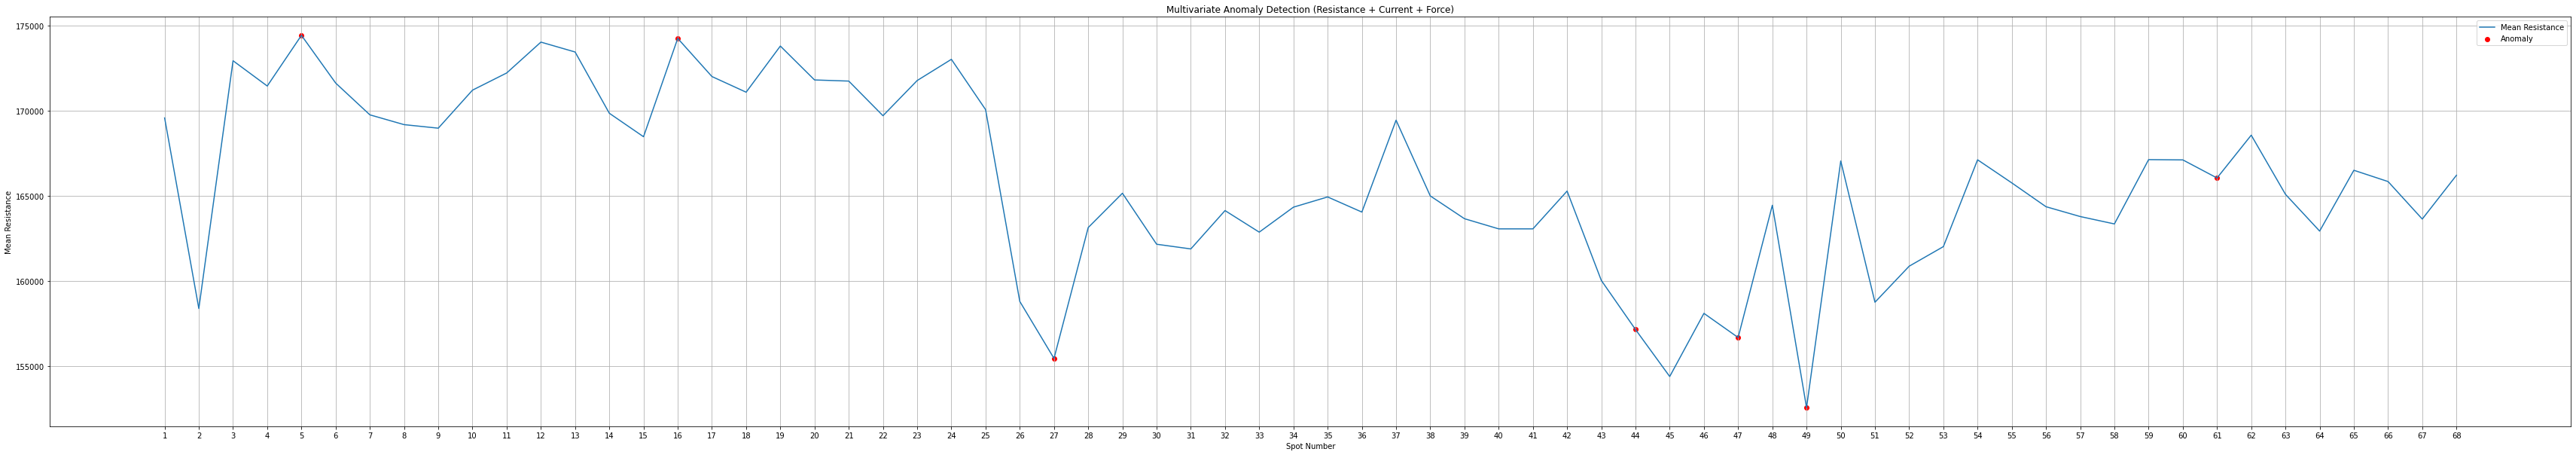

Anomalous spots: [5, 16, 27, 44, 47, 49, 61]


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt

# Assuming these are aligned by index
resistance_means = df_Resistance['mean'].values
current_means = df_Current['mean'].values
force_means = df_Force['mean'].values
spot_numbers = df_Resistance.index.values  # assuming same as current and force

# Step 1: Combine into multivariate feature matrix
X = np.vstack([resistance_means, current_means, force_means]).T  # shape: (n_samples, 3)

# Step 2: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train Isolation Forest
iso = IsolationForest(contamination=0.1, random_state=42)
labels = iso.fit_predict(X_scaled)  # -1 = anomaly, 1 = normal

# Step 4: Visualize using resistance mean
plt.figure(figsize=(60, 10))
plt.plot(spot_numbers, resistance_means, label='Mean Resistance')
plt.scatter(
    np.array(spot_numbers)[labels == -1],
    resistance_means[labels == -1],
    color='red', label='Anomaly'
)
plt.xlabel("Spot Number")
plt.xticks(np.array(spot_numbers))
plt.ylabel("Mean Resistance")
plt.legend()
plt.title("Multivariate Anomaly Detection (Resistance + Current + Force)")
plt.grid(True)
plt.show()

# Step 5: List of anomalous spots
anomalous_spots = spot_numbers[labels == -1]
print("Anomalous spots:", anomalous_spots.tolist())


In [36]:
anomalous_spots = spot_numbers[labels == -1]
print("Anomalous spots:", anomalous_spots.tolist())


Anomalous spots: [5, 16, 44, 49]


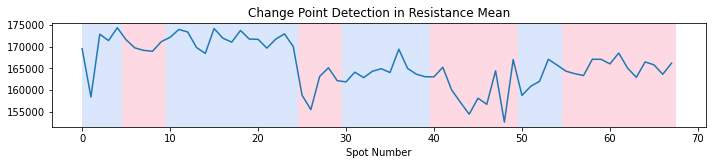

Detected change points at spot indices: [5, 10, 25, 30, 40, 50, 55, 68]


In [20]:
import ruptures as rpt

# Signal = 1D array of mean resistances
signal = np.array(resistance_means)

# Use Pelt or Binary Segmentation
model = "rbf"  # or "l2" depending on data behavior
algo = rpt.Pelt(model=model).fit(signal)
result = algo.predict(pen=0.25)  # Try tuning 'pen'

# Plot
rpt.display(signal, result)
plt.title("Change Point Detection in Resistance Mean")
plt.xlabel("Spot Number")
plt.show()

# Change points will mark spots where shift occurred
change_points = result
print("Detected change points at spot indices:", change_points)


In [52]:
img_data=pd.DataFrame({'Spot No.':[1,2,3,4,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,37,39,50,58,59,60,61,62,63,64,65,66,67],
                       'Radius':[2.776,2.785,2.323,2.252,2.359,2.085,2.626,2.277,2.41,2.126,2.212,2.223,2.627,2.336,2.549,2.35,2.312,2.771,2.359,2.243,3.107,2.514,2.289,2.283,3.278,2.575,2.069,2.082,2.538,2.506,2.377,3.319,3.733,2.501,2.475,2.428,3.86,3.673,3.831,3.85,3.922,3.915,3.908,4.03],
                       'Spot Area':[28.856,28.458,23.074,21.848,22.517,20.796,np.NaN,17.806,20.056,21.172,19.163,21.302,27.583,22.1,25.241,19.953,23.594,26.673,19.779,21.923,22.588,23.288,21.476,21.109,18.688,20.336,24.961,20.579,22.974,23.244,23.31,22.564,23.788,27.271,22.412,21.824,22.46,21.573,23.978,24.967,23.414,24.508,24.265,27.632]},
                       columns=['Spot No.', 'Radius', 'Spot Area'])

df=img_data.copy()
df=df.dropna()

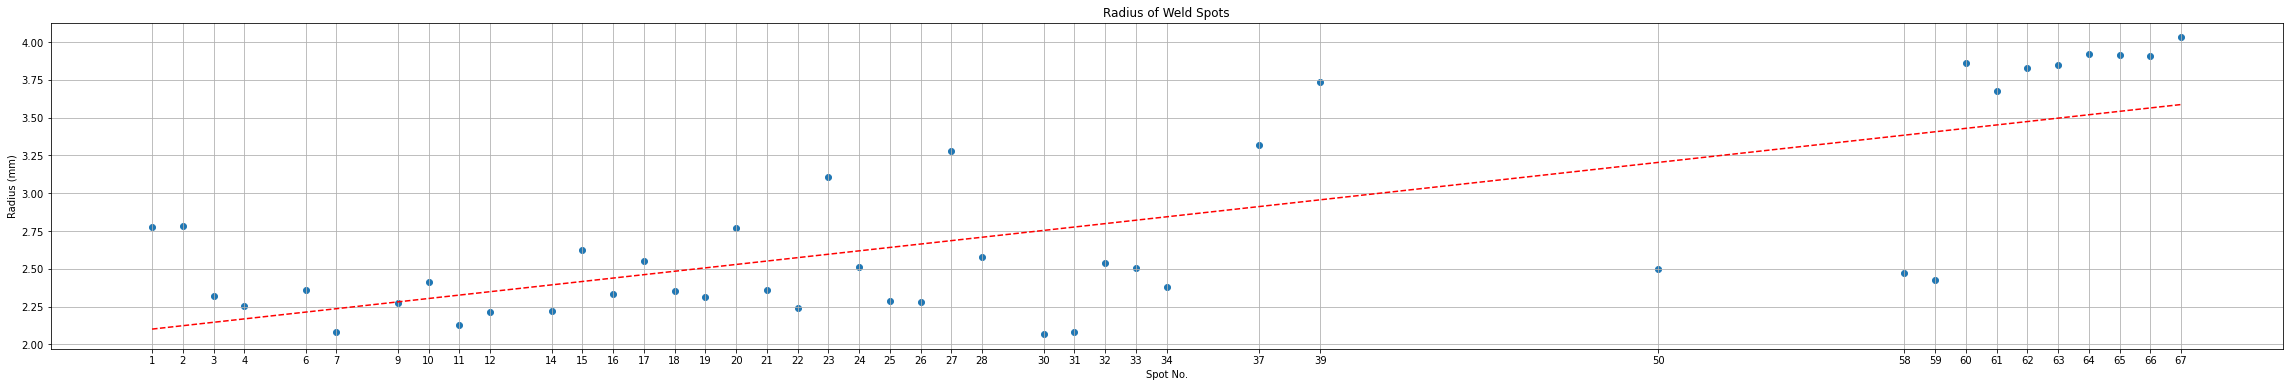

In [53]:
plt.figure(figsize=(40,6))
plt.title('Radius of Weld Spots')
plt.scatter(df['Spot No.'],df['Radius'])
plt.xlabel('Spot No.')
plt.ylabel('Radius (mm)')
plt.xticks(df['Spot No.'])
coeffs = np.polyfit(df['Spot No.'],df['Radius'] , deg=1)
trendline = np.polyval(coeffs, df['Spot No.'])
plt.plot(df['Spot No.'], trendline, color='red', label='Linear Trendline',linestyle='dashed')
plt.grid(True)

In [26]:
import math
k=0.0297
Radius_calculated=[]
for i in range(len(resistance_means)):
    F=df_Force['mean'].iloc[i]
    I=df_Current['mean'].iloc[i]

    numerator = 8 * k * F * I * (16.1 / 2)
    denominator = math.pi ** 3
    r = (numerator / denominator) ** (1/8) * (i+1) ** (1/8)
    Radius_calculated.append(r)
    


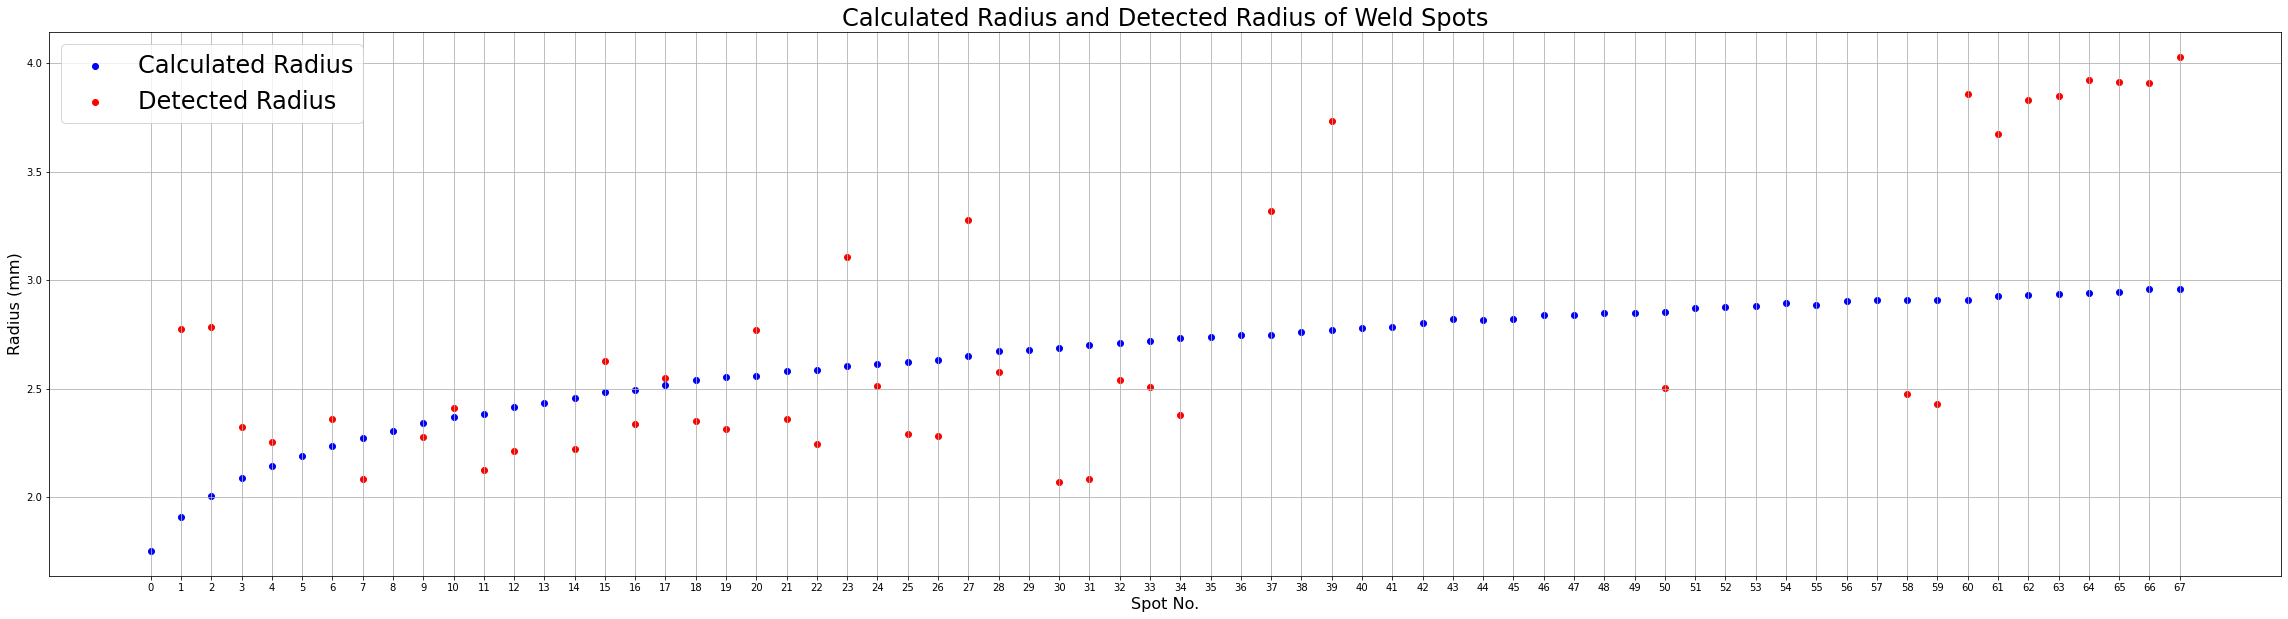

In [64]:
plt.figure(figsize=(40,10))
spots=np.arange(len(Radius_calculated))
plt.title('Calculated Radius and Detected Radius of Weld Spots',fontsize=24)
plt.scatter(spots,Radius_calculated,color='blue',label='Calculated Radius')
plt.scatter(df['Spot No.'],df['Radius'],color='red',label='Detected Radius')
plt.xlabel('Spot No.',fontsize=16)
plt.ylabel('Radius (mm)',fontsize=16)
plt.xticks(spots)
# coeffs = np.polyfit(spots, Radius_calculated, deg=1)
# trendline = np.polyval(coeffs, spots)
# plt.plot(spots, trendline, color='red', label='Linear Trendline',linestyle='dashed')
plt.grid(True)
plt.legend(fontsize=24)

# Space for rough


In [ ]:
data_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{1}.xlsx"
data=pd.read_excel(data_path)
# print("The RAW DATA info is:")
# data.info()

#preprocessing to get it in my order
df=data.copy() #copying it so original data is not affected
df=df.dropna()
df=df.drop(["Time - Voltage","Time - Resistance","Time - Force"],axis=1)
df=df.rename({
    "Time - Current":"Time",
    "Current (kA) - Current":"Current (kA)",
    "Voltage (V) - Voltage":"Voltage (V)",
    "Resistance (Ohm) - Resistance":"Resistance (Ohm)",
    "Force (kg) - Force":"Force (kgf)"
},axis=1)

Text(0.5, 1.0, 'Spot 1 Voltage Curve')

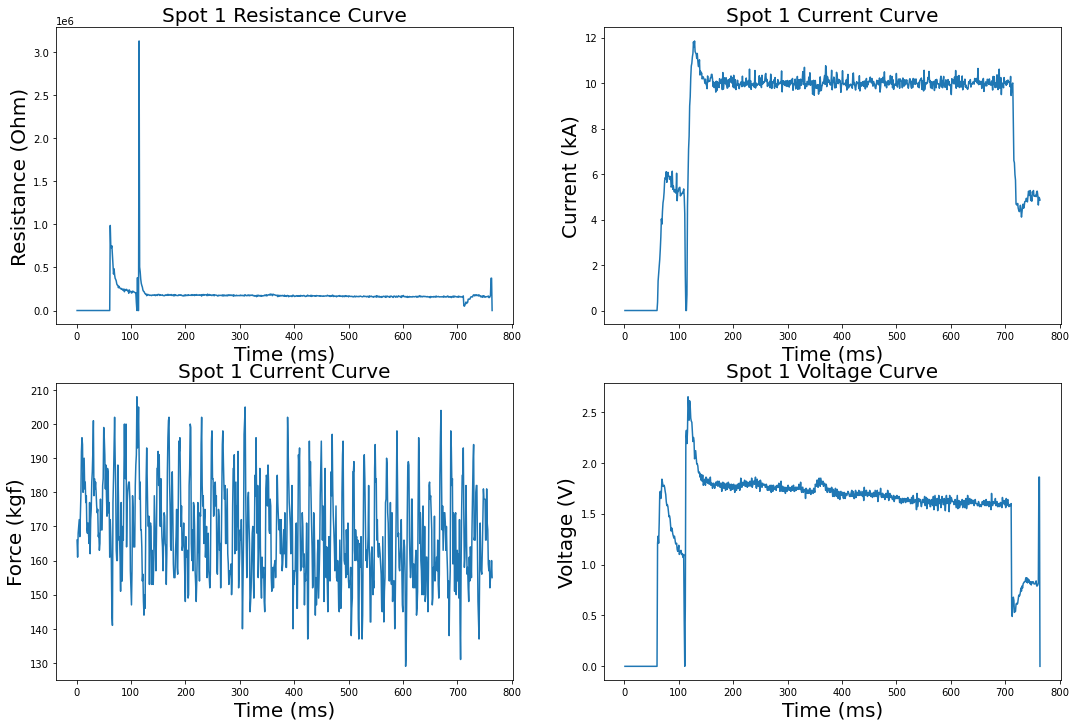

In [ ]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
plt.plot(df["Time"],df["Resistance (Ohm)"])
plt.xlabel("Time (ms)",fontsize=20)
plt.ylabel("Resistance (Ohm)",fontsize=20)
plt.title("Spot 1 Resistance Curve",fontsize=20)

plt.subplot(2,2,2)
plt.plot(df["Time"],df["Current (kA)"])
plt.xlabel("Time (ms)",fontsize=20)
plt.ylabel("Current (kA)",fontsize=20)
plt.title("Spot 1 Current Curve",fontsize=20)

plt.subplot(2,2,3)
plt.plot(df["Time"],df["Force (kgf)"])
plt.xlabel("Time (ms)",fontsize=20)
plt.ylabel("Force (kgf)",fontsize=20)
plt.title("Spot 1 Current Curve",fontsize=20)

plt.subplot(2,2,4)
plt.plot(df["Time"],df["Voltage (V)"])
plt.xlabel("Time (ms)",fontsize=20)
plt.ylabel("Voltage (V)",fontsize=20)
plt.title("Spot 1 Voltage Curve",fontsize=20)

In [ ]:
path1=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{1}.xlsx"
path2=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{2}.xlsx"
path3=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{3}.xlsx"
path4=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{4}.xlsx"
path5=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{5}.xlsx"
path6=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{6}.xlsx"
path7=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{7}.xlsx"
path8=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{8}.xlsx"
path9=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{9}.xlsx"
path10=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{10}.xlsx"


path11=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{11}.xlsx"
path24=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{24}.xlsx"
path27=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{27}.xlsx"
path28=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{28}.xlsx"
path34=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{34}.xlsx"
path50=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{50}.xlsx"
path68=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{68}.xlsx"

# time=np.arange(0,764,1)
time=None

df1=pre_process(data_path=path1,timestamps=time)
df2=pre_process(data_path=path2,timestamps=time)
df3=pre_process(data_path=path3,timestamps=time)
df4=pre_process(data_path=path4,timestamps=time)
df5=pre_process(data_path=path5,timestamps=time)
df6=pre_process(data_path=path6,timestamps=time)
df7=pre_process(data_path=path7,timestamps=time)
df8=pre_process(data_path=path8,timestamps=time)
df9=pre_process(data_path=path9,timestamps=time)
df10=pre_process(data_path=path10,timestamps=time)
df11=pre_process(data_path=path11,timestamps=time)
df24=pre_process(data_path=path24,timestamps=time)
df27=pre_process(data_path=path27,timestamps=time)
df28=pre_process(data_path=path28,timestamps=time)
df34=pre_process(data_path=path34,timestamps=time)
df50=pre_process(data_path=path50,timestamps=time)
df68=pre_process(data_path=path68,timestamps=time)







In [ ]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
plt.plot(df1["Time"],df1["Resistance (Ohm)"])
plt.xlabel("Time (ms)",fontsize=20)
plt.ylabel("Resistance (Ohm)",fontsize=20)
plt.title("Spot 1 Resistance Curve",fontsize=20)


plt.tight_layout()
plt.show()



In [ ]:



rp_mat_F=get_rp_matrix(signal_values=df11["Force (kgf)"])
rp_mat_R=get_rp_matrix(signal_values=df11["Resistance (Ohm)"],N=0.03)
rp_mat_V=get_rp_matrix(signal_values=df11["Voltage (V)"],N=0.03)
rp_mat_I=get_rp_matrix(signal_values=df11["Current (kA)"],N=0.03)
plt.figure(figsize=(12, 6))
plt.subplot(2,2,1)
plt.title('Force RP Map')
plt.imshow(rp_mat_F, cmap='viridis', origin='lower')
plt.axis('off')
plt.subplot(2,2,2)
plt.title('Voltage RP Map')
plt.imshow(rp_mat_V, cmap='viridis', origin='lower')
plt.axis('off')
plt.subplot(2,2,3)
plt.title('Resistance RP Map')
plt.imshow(rp_mat_R, cmap='viridis', origin='lower')
plt.axis('off')
plt.subplot(2,2,4)
plt.title('Current RP Map')
plt.imshow(rp_mat_I, cmap='viridis', origin='lower')
plt.axis('off')
plt.tight_layout()

plt.show()


In [ ]:
for i in range(1,69):
    data_path=rf"C:\Users\pavan kumar\OneDrive\Desktop\Internship Work Docs\Spot data 24-05-2025\{i}.xlsx"
    time=np.arange(0,764,1)
    df=pre_process(data_path=data_path,timestamps=time)
    rp_mat=get_rp_matrix(signal_values=df["Resistance (Ohm)"],N=0.01)
    plt.figure(figsize=(12,6))
    plt.suptitle(f'Spot {i}')
    plt.subplot(1,2,1)
    plt.title('Raw Resistance Graph')
    plt.plot(df["Time"],df["Resistance (Ohm)"])
    plt.scatter(df.iloc[df["Resistance (Ohm)"].argmax()].Time,df["Resistance (Ohm)"].max())
    plt.annotate(f'{(df.iloc[df["Resistance (Ohm)"].argmax()].Time,df["Resistance (Ohm)"].max())}', # The text label
             (df.iloc[df["Resistance (Ohm)"].argmax()].Time,df["Resistance (Ohm)"].max()), # The (x,y) coordinates of the point
             xytext=(1, 1), # Offset from the point for the text
             textcoords='offset points',
             ha='left', # Horizontal alignment
             va='bottom')
    plt.xlabel('Time (ms)')
    plt.ylabel('Resitance (Ohm)')
    plt.subplot(1,2,2)
    plt.title("RP Map")
    plt.imshow(rp_mat,cmap='viridis',origin='lower')
    plt.savefig(rf'Sensor Data Analysis\RP Maps\Resistance\{i}.jpg',format='jpg',dpi=300)

# dataframes of signals


In [30]:
# timestamps=np.arange(118,713,1)
timestamps=None

data_R=get_df_sensor(sensor='Resistance (Ohm)',spotf=1,spotl=68,timestamps=timestamps)
data_F=get_df_sensor(sensor='Force (kgf)', spotf=1,spotl=68,timestamps=timestamps)
data_I=get_df_sensor(sensor='Current (kA)',spotf=1,spotl=68,timestamps=timestamps)

PCA reduced dimensions from 763 to 50 components.


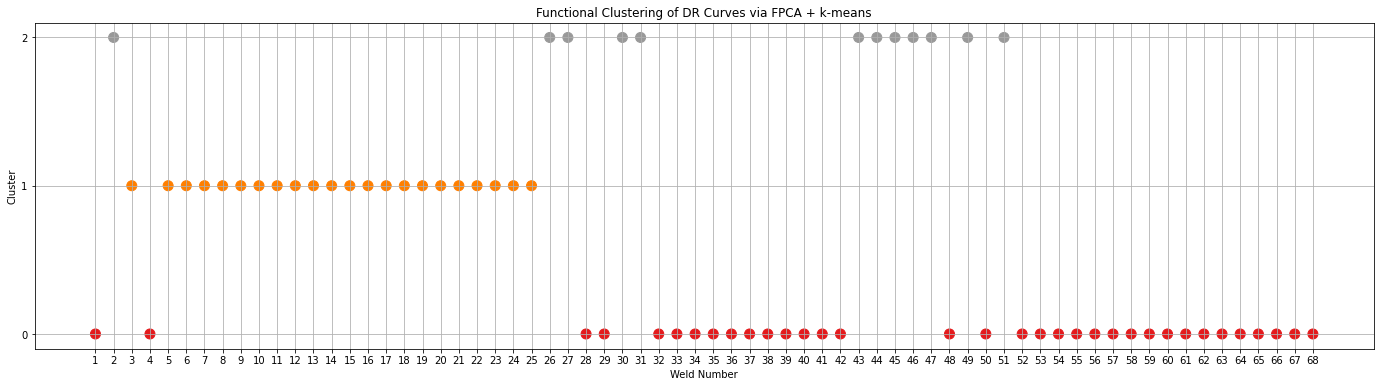

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Load DR data (763 × 68), transpose so each weld is a sample (row)
X = data_R.T  # Now shape = (68 welds, 763 time steps)

# Step 2: Standardize data across time points (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA
pca = PCA(n_components=0.95)  # retain 99% of variance
X_pca = pca.fit_transform(X_scaled)

print(f"PCA reduced dimensions from {X.shape[1]} to {X_pca.shape[1]} components.")

# Step 4: KMeans clustering (you can try GMM as well)
n_clusters = 3  # based on Zhou et al. (stable, transition, worn)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Step 5: Add cluster labels to welds
cluster_df = pd.DataFrame({'Weld': X.index, 'Cluster': cluster_labels})

# Step 6: Plot cluster assignments
plt.figure(figsize=(24, 6))
plt.scatter(cluster_df['Weld'], cluster_df['Cluster'], c=cluster_labels, cmap='Set1', s=100)
plt.xlabel("Weld Number")
plt.xticks(cluster_df['Weld'])
plt.ylabel("Cluster")
plt.yticks([0,1,2])
plt.title("Functional Clustering of DR Curves via FPCA + k-means")
plt.grid(True)
plt.show()


PCA reduced dimensions from 763 to 60 components.


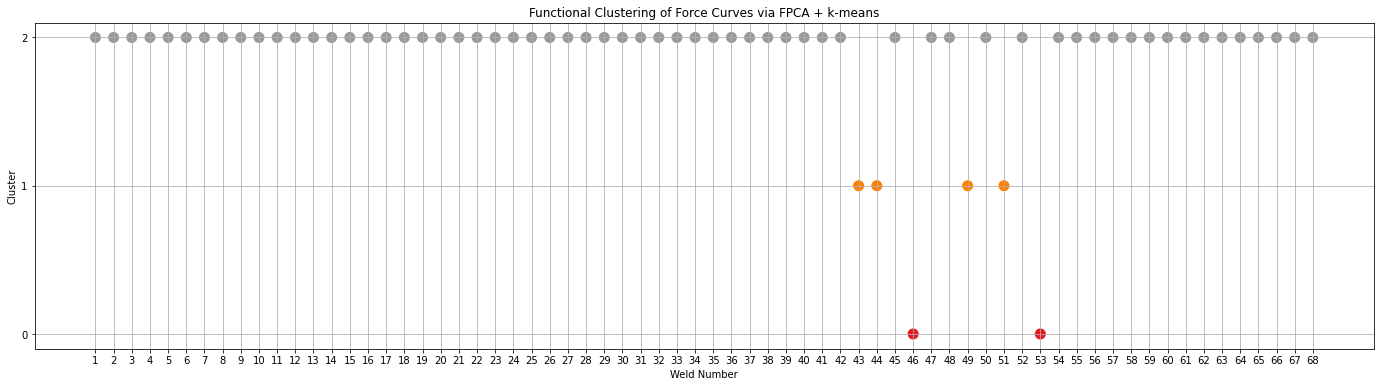

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Load DR data (763 × 68), transpose so each weld is a sample (row)
X = data_I.T  # Now shape = (68 welds, 763 time steps)

# Step 2: Standardize data across time points (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA
pca = PCA(n_components=0.95)  # retain 99% of variance
X_pca = pca.fit_transform(X_scaled)

print(f"PCA reduced dimensions from {X.shape[1]} to {X_pca.shape[1]} components.")

# Step 4: KMeans clustering (you can try GMM as well)
n_clusters = 3  # based on Zhou et al. (stable, transition, worn)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Step 5: Add cluster labels to welds
cluster_df = pd.DataFrame({'Weld': X.index, 'Cluster': cluster_labels})

# Step 6: Plot cluster assignments
plt.figure(figsize=(24, 6))
plt.scatter(cluster_df['Weld'], cluster_df['Cluster'], c=cluster_labels, cmap='Set1', s=100)
plt.xlabel("Weld Number")
plt.xticks(cluster_df['Weld'])
plt.ylabel("Cluster")
plt.yticks([0,1,2])
plt.title("Functional Clustering of Force Curves via FPCA + k-means")
plt.grid(True)
plt.show()


## Some other implementations


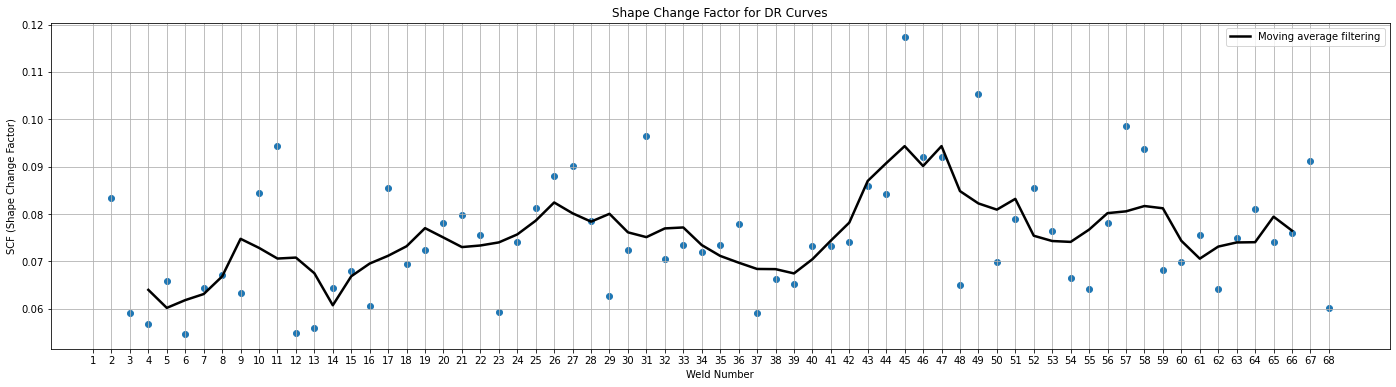

In [ ]:

scf_df=compute_scf(data=data_R,slope=4,shift=2,time=data_R.T.columns)

#plotting the scf values
plt.figure(figsize=(24,6))
plt.scatter(scf_df.T.columns[1:],scf_df['SCF'][1:])
scf_series = scf_df['SCF'][1:]
window = 5  # same as your smoothing window
scf_smooth = scf_series.rolling(window=window, center=True).mean()
plt.plot(scf_series.index, scf_smooth, color='black', linewidth=2.5, label='Moving average filtering')
plt.title('Shape Change Factor for DR Curves')
plt.xlabel("Weld Number")
plt.xticks(scf_df.T.columns)
plt.ylabel("SCF (Shape Change Factor)")
plt.grid()
plt.legend()

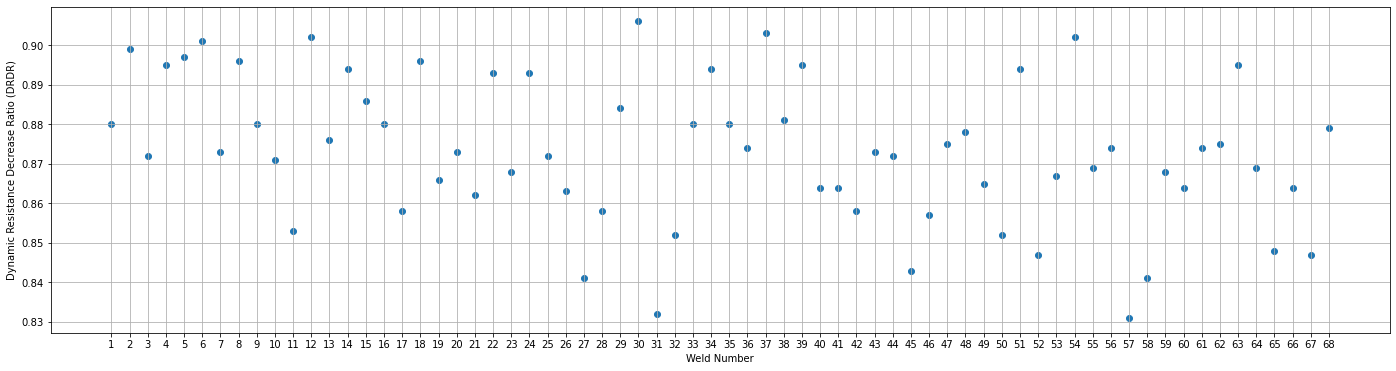

In [229]:
DRDR=[]
for i in range(1,69,1):
    diff=((data_R[i].max()-data_R[i].iloc[761])/data_R[i].max())
    DRDR.append(np.round(diff,3))

plt.figure(figsize=(24,6))
plt.scatter(data_R.columns,DRDR)
plt.xlabel("Weld Number")
plt.xticks(data_R.columns)
plt.ylabel("Dynamic Resistance Decrease Ratio (DRDR)")
plt.grid()

c:\Users\pavan kumar\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


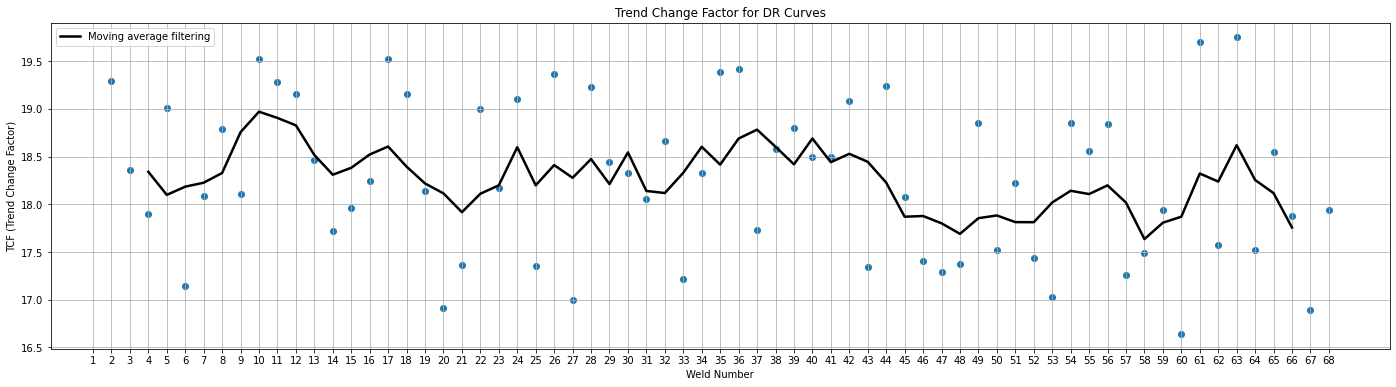

In [270]:
# Step 1: First-order difference
# Smooth the entire DR dataset before any computation
# data_R_smooth = data_R.rolling(window=5, center=True).mean()


diff_data = data_R.diff().iloc[1:]

# Step 2: Sigmoid transform
beta = 0.5
sigmoid_diff = 1 / (1 + np.exp(-beta * diff_data))

# Step 3: TCF computation
ref_sigmoid = sigmoid_diff.iloc[:, 0]
tcf_values = {}
for col in sigmoid_diff.columns:
    current = sigmoid_diff[col]
    tcf = np.sqrt(np.sum((current - ref_sigmoid) ** 2))
    tcf_values[col] = tcf
tcf_df = pd.DataFrame.from_dict(tcf_values, orient='index', columns=['TCF'])

plt.figure(figsize=(24,6))
plt.scatter(tcf_df.T.columns[1:],tcf_df['TCF'][1:])
tcf_series = tcf_df['TCF'][1:]
window = 5  # same as your smoothing window
tcf_smooth = tcf_series.rolling(window=window, center=True).mean()
plt.plot(tcf_series.index, tcf_smooth, color='black', linewidth=2.5, label='Moving average filtering')

plt.xlabel("Weld Number")
plt.xticks(tcf_df.T.columns)
plt.title('Trend Change Factor for DR Curves')
plt.ylabel("TCF (Trend Change Factor)")
plt.legend()
plt.grid()

PCA reduced dimensions from 763 to 50 components.


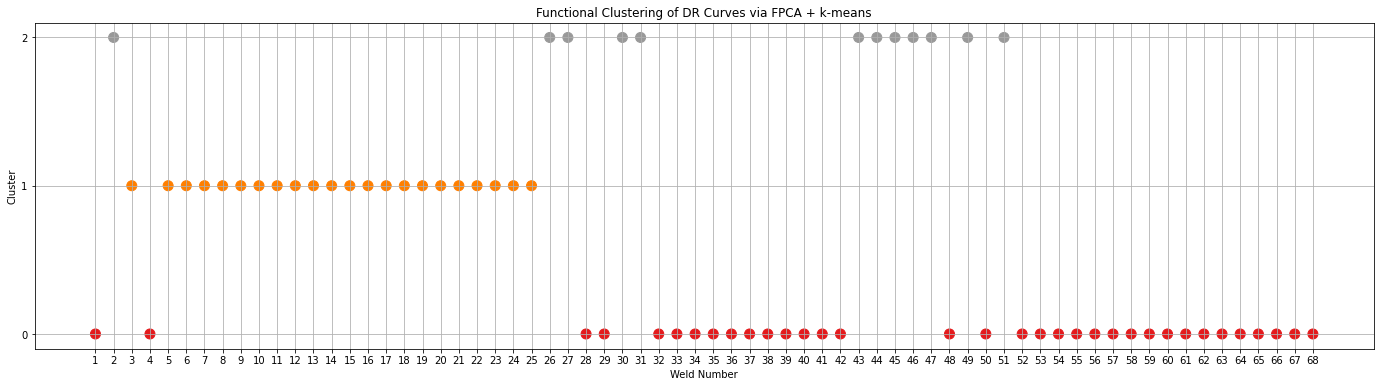

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Load DR data (763 × 68), transpose so each weld is a sample (row)
X = data_R.T  # Now shape = (68 welds, 763 time steps)

# Step 2: Standardize data across time points (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA
pca = PCA(n_components=0.95)  # retain 99% of variance
X_pca = pca.fit_transform(X_scaled)

print(f"PCA reduced dimensions from {X.shape[1]} to {X_pca.shape[1]} components.")

# Step 4: KMeans clustering (you can try GMM as well)
n_clusters = 3  # based on Zhou et al. (stable, transition, worn)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Step 5: Add cluster labels to welds
cluster_df = pd.DataFrame({'Weld': X.index, 'Cluster': cluster_labels})

# Step 6: Plot cluster assignments
plt.figure(figsize=(24, 6))
plt.scatter(cluster_df['Weld'], cluster_df['Cluster'], c=cluster_labels, cmap='Set1', s=100)
plt.xlabel("Weld Number")
plt.xticks(cluster_df['Weld'])
plt.ylabel("Cluster")
plt.yticks([0,1,2])
plt.title("Functional Clustering of DR Curves via FPCA + k-means")
plt.grid(True)
plt.show()


In [261]:
cluster_df[cluster_df['Cluster']==2]

,Weld,Cluster
1,2,2
25,26,2
26,27,2
29,30,2
30,31,2
42,43,2
43,44,2
44,45,2
45,46,2
46,47,2
